# Scraping Jumia Ecommerce Site: DSE HACKATHON

## Import libraries

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import os
import time
import copy

import scripts.gemini_api_call as gemini_call
from scripts import scraper
import importlib

### Create array of products on each page, add each to product dictionary & append to array iteratively

In [115]:
all_products_list = []

def append_one_product_details_dictionary_to_list(pg):
    # print(f"Appending page {pg} products' details to array")
    
    page_products_details_soup = soup.find_all("article", class_="prd _fb col c-prd")
    
    for detail in page_products_details_soup:
        details_dict = {"name": detail.find("h3", class_="name").text.strip(),
                        "new_price": detail.find("div", class_="prc").text.strip(),
                        "old_price": detail.find("div", class_="old").text.strip() if detail.find("div", class_="old") else None,
                        "discount": detail.find("div", class_="bdg _dsct _sm").text.strip() if detail.find("div", class_="bdg _dsct _sm") else None,
                        "rating": detail.find("div", class_="stars _s").text.strip() if detail.find("div", class_="stars _s") else None,
                        "votes": detail.find("div", class_="rev").text.strip() if detail.find("div", class_="rev") else None}
        all_products_list.append(details_dict)


# len(product_details_clean)

### Fetch webdata, convert to BeautifulSoup Object, add product details dictionary to list

In [116]:
# Declare the products’ url & the total webpage count
other_pages_url = "https://www.jumia.co.ke/all-products/?page="
webpage_num_total = 50

# If scraped products csv doesn't exist, run the scraper function below & save products to csv ELSE continue & read csv
if not os.path.exists('../data/raw/all_products_list_raw.csv'):
    for page in range(1, webpage_num_total+1, 1):
        other_pages_url = "https://www.jumia.co.ke/all-products/?page="
        page = str(page)
        other_pages_url = other_pages_url + page
        response = scraper.fetch_html_data(other_pages_url)
        # time.sleep(2.5)
        soup = scraper.convert_web_data_to_beautiful_soup_obj(response)
        append_one_product_details_dictionary_to_list(page)
    
    # Convert scraped list to dataframe
    df = pd.DataFrame(all_products_list)
    # Save scraped dataframe to csv to prevent scraping each time I run the notebook
    df.to_csv('../data/raw/all_products_list_raw.csv')

### Check product count

In [117]:
# Read csv and specify index column to prevent creation of another redundant index
products_df = pd.read_csv('../data/raw/all_products_list_raw.csv', index_col=0)  # Read products list from csv

### Inspect products list dataframe

In [118]:
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,KSh 912,"KSh 1,460",38%,4.7 out of 5,4.7 out of 5(721)
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,KSh 628,NaN,NaN,4.3 out of 5,4.3 out of 5(43)
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,"KSh 1,400","KSh 1,750",20%,4.3 out of 5,4.3 out of 5(1546)
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,KSh 887,"KSh 1,560",43%,4.5 out of 5,4.5 out of 5(2293)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,KSh 651,"KSh 1,040",37%,4.6 out of 5,4.6 out of 5(680)


In [119]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       2000 non-null   object
 1   new_price  2000 non-null   object
 2   old_price  1847 non-null   object
 3   discount   1847 non-null   object
 4   rating     134 non-null    object
 5   votes      134 non-null    object
dtypes: object(6)
memory usage: 109.4+ KB


In [120]:
products_df.shape

(2000, 6)

# Data Cleaning Section

### Clean new_price column

In [121]:
products_df['new_price'][1]

'KSh 628'

In [122]:
# Remove currency name 'Ksh' 
products_df['new_price'] = products_df['new_price'].apply(lambda x: x.split(' ')[1] if x is not None and isinstance(x,str) else x) 

In [123]:
print(type(products_df['new_price'][1]))
print(products_df['new_price'].head())

<class 'str'>
0      912
1      628
2    1,400
3      887
4      651
Name: new_price, dtype: object


In [124]:
# Remove comma from thousands price values
products_df['new_price'] = products_df['new_price'].apply(lambda x: x.replace(',','') if ',' in x and isinstance(x,str) else x)
products_df['new_price'].head()

0     912
1     628
2    1400
3     887
4     651
Name: new_price, dtype: object

In [125]:
print(type(products_df['new_price'][1]))

<class 'str'>


In [126]:
# Convert new_price column to float
products_df['new_price'] = products_df['new_price'].apply(lambda x: float(x) if x is not None else x)

In [127]:
print(type(products_df['new_price'][1]))
print(products_df['new_price'].dtype)

<class 'numpy.float64'>
float64


In [128]:
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,912.0,"KSh 1,460",38%,4.7 out of 5,4.7 out of 5(721)
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,628.0,NaN,NaN,4.3 out of 5,4.3 out of 5(43)
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,"KSh 1,750",20%,4.3 out of 5,4.3 out of 5(1546)
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,887.0,"KSh 1,560",43%,4.5 out of 5,4.5 out of 5(2293)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,651.0,"KSh 1,040",37%,4.6 out of 5,4.6 out of 5(680)


In [129]:
# Saving stage one (new_price) data cleaning file to csv
products_df.to_csv("../data/processed/1_all_products_new_price_cleaned.csv")

### Clean old_price column

In [130]:
# Read csv file cleaned in the previous stage (new_price column) & convert to dataframe
products_df = pd.read_csv("../data/processed/1_all_products_new_price_cleaned.csv", index_col=0)

# Use [:10] notation to print the first 10 values
products_df['old_price'].unique()[:10]

array(['KSh 1,460', nan, 'KSh 1,750', 'KSh 1,560', 'KSh 1,040',
       'KSh 1,200', 'KSh 1,302', 'KSh 1,295', 'KSh 3,827', 'KSh 815'],
      dtype=object)

In [131]:
# Remove currency name 'Ksh'
# type(products_df['old_price'][1])
products_df['old_price'] = products_df['old_price'].apply(lambda x: x.split(' ')[1] if x is not None and isinstance(x,str) else x)
products_df['old_price'].head()

0    1,460
1      NaN
2    1,750
3    1,560
4    1,040
Name: old_price, dtype: object

In [132]:
# Remove commas from values
products_df['old_price'] = products_df['old_price'].apply(lambda x: x.replace(',','') if x is not None and isinstance(x,str) else x)
products_df['old_price'].head(10)

0    1460
1     NaN
2    1750
3    1560
4    1040
5    1200
6    1750
7     NaN
8    1040
9    1302
Name: old_price, dtype: object

In [133]:
# Convert the string values into floats
products_df['old_price'] = products_df['old_price'].apply(lambda x: float(x) if x is not None else x)
products_df['old_price'].head(10)

0    1460.0
1       NaN
2    1750.0
3    1560.0
4    1040.0
5    1200.0
6    1750.0
7       NaN
8    1040.0
9    1302.0
Name: old_price, dtype: float64

In [134]:
products_df['old_price']

0        1460.0
1           NaN
2        1750.0
3        1560.0
4        1040.0
         ...   
1995      731.0
1996     2778.0
1997    15405.0
1998     1197.0
1999    21475.0
Name: old_price, Length: 2000, dtype: float64

In [135]:
# Index 18 from above was null. So checking its type: 
print(type(products_df['old_price'][18]))
print(products_df['old_price'].dtype)

<class 'numpy.float64'>
float64


In [136]:
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,912.0,1460.0,38%,4.7 out of 5,4.7 out of 5(721)
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,628.0,NaN,NaN,4.3 out of 5,4.3 out of 5(43)
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.0,20%,4.3 out of 5,4.3 out of 5(1546)
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,887.0,1560.0,43%,4.5 out of 5,4.5 out of 5(2293)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,651.0,1040.0,37%,4.6 out of 5,4.6 out of 5(680)


In [137]:
# Saving stage two data (old_price column) cleaning dataframe to csv
products_df.to_csv("../data/processed/2_all_products_old_price_cleaned.csv")

### Cleaning 'discount' column

In [138]:
# Read csv file from stage 2 (old_price column cleanup) to get dataframe
products_df = pd.read_csv("../data/processed/2_all_products_old_price_cleaned.csv", index_col=0)

# Use [:10] notation to print the first 10 values
products_df['discount'].unique()[:10]

array(['38%', nan, '20%', '43%', '37%', '39%', '29%', '15%', '35%', '1%'],
      dtype=object)

In [139]:
# Remove the percent sign
products_df['discount'] = products_df['discount'].apply(lambda x: x.replace('%','') if x is not None and isinstance(x,str) else x)
products_df['discount'].unique()

array(['38', nan, '20', '43', '37', '39', '29', '15', '35', '1', '30',
       '8', '5', '7', '9', '17', '4', '87', '42', '28', '21', '23', '36',
       '24', '45', '44', '50', '47', '46', '49', '48', '40', '33', '53',
       '25', '16', '19', '18', '41', '13', '34', '22', '31', '32', '27',
       '10'], dtype=object)

In [140]:
# Convert values into float & divide by 100 to represent the percentages as decimal values
products_df['discount'] = products_df['discount'].apply(lambda x: float(x)/100 if x is not None else x)
products_df['discount'].unique()  # A numbers now floats and None replaced with NaN

array([0.38,  nan, 0.2 , 0.43, 0.37, 0.39, 0.29, 0.15, 0.35, 0.01, 0.3 ,
       0.08, 0.05, 0.07, 0.09, 0.17, 0.04, 0.87, 0.42, 0.28, 0.21, 0.23,
       0.36, 0.24, 0.45, 0.44, 0.5 , 0.47, 0.46, 0.49, 0.48, 0.4 , 0.33,
       0.53, 0.25, 0.16, 0.19, 0.18, 0.41, 0.13, 0.34, 0.22, 0.31, 0.32,
       0.27, 0.1 ])

In [141]:
# Check head once more
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,912.0,1460.0,0.38,4.7 out of 5,4.7 out of 5(721)
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,628.0,NaN,NaN,4.3 out of 5,4.3 out of 5(43)
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.0,0.20,4.3 out of 5,4.3 out of 5(1546)
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,887.0,1560.0,0.43,4.5 out of 5,4.5 out of 5(2293)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,651.0,1040.0,0.37,4.6 out of 5,4.6 out of 5(680)


In [142]:
# Saving stage three data cleaning file to csv
products_df.to_csv("../data/processed/3_all_products_discount_cleaned.csv")

### Cleaning the rating column

In [143]:
# Read file cleaned in prior stage (discount column) to get dataframe
products_df = pd.read_csv("../data/processed/3_all_products_discount_cleaned.csv", index_col=0)

# Check for unique values first
products_df['rating'].unique()[:10]

array(['4.7 out of 5', '4.3 out of 5', '4.5 out of 5', '4.6 out of 5',
       '4.4 out of 5', '4.2 out of 5', '4.8 out of 5', '4 out of 5',
       '3 out of 5', '3.4 out of 5'], dtype=object)

In [144]:
# Split rating string values into 4 elements and select the first element unless its None(left as is)
products_df['rating'] = products_df['rating'].apply(lambda x: x.split(' ')[0] if x is not None and isinstance(x,str) else x)
products_df['rating'].unique()

array(['4.7', '4.3', '4.5', '4.6', '4.4', '4.2', '4.8', '4', '3', '3.4',
       '4.9', '3.8', '5', nan, '2.7', '3.7', '4.1', '1', '3.5', '3.9'],
      dtype=object)

In [145]:
# Convert the values into float
products_df['rating'] = products_df['rating'].apply(lambda x: float(x) if x is not None else x)
print(products_df['rating'].dtype)

float64


In [146]:
products_df.head(20)

,name,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,912.0,1460.0,0.38,4.7,4.7 out of 5(721)
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,628.0,NaN,NaN,4.3,4.3 out of 5(43)
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.0,0.20,4.3,4.3 out of 5(1546)
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,887.0,1560.0,0.43,4.5,4.5 out of 5(2293)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,651.0,1040.0,0.37,4.6,4.6 out of 5(680)
5,Garnier Even & Matte Vitamin C Protection Crea...,960.0,1200.0,0.20,4.3,4.3 out of 5(1078)
6,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,1750.0,0.20,4.4,4.4 out of 5(3845)
7,Nunix R5 Hot & Normal Free Standing Water Disp...,4180.0,NaN,NaN,4.2,4.2 out of 5(101)
8,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",651.0,1040.0,0.37,4.6,4.6 out of 5(853)
9,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,800.0,1302.0,0.39,4.7,4.7 out of 5(1162)


In [147]:
# Saving stage four data cleaning file to csv
products_df.to_csv("../data/processed/4_all_products_rating_cleaned.csv")

### Cleaning the 'votes' column

In [148]:
# Read csv file saved in prior cleaning stage (rating column) to obtain dataframe
products_df = pd.read_csv("../data/processed/4_all_products_rating_cleaned.csv", index_col=0)

# Explore unique values
products_df['votes'].unique()[:10]

array(['4.7 out of 5(721)', '4.3 out of 5(43)', '4.3 out of 5(1546)',
       '4.5 out of 5(2293)', '4.6 out of 5(680)', '4.3 out of 5(1078)',
       '4.4 out of 5(3845)', '4.2 out of 5(101)', '4.6 out of 5(853)',
       '4.7 out of 5(1162)'], dtype=object)

In [149]:
# Extract the votes count with string manipulation methods & convert values to floats
products_df['votes'] = products_df['votes'].apply(lambda x: float(x.split('(')[1].split(')')[0]) if x is not None and isinstance(x,str) else x)
products_df['votes'].unique()[:15]

array([ 721.,   43., 1546., 2293.,  680., 1078., 3845.,  101.,  853.,
       1162.,  786., 4808.,  250., 2073.,  663.])

In [150]:
products_df.head(10)

,name,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,912.0,1460.0,0.38,4.7,721.0
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,628.0,NaN,NaN,4.3,43.0
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.0,0.20,4.3,1546.0
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,887.0,1560.0,0.43,4.5,2293.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,651.0,1040.0,0.37,4.6,680.0
5,Garnier Even & Matte Vitamin C Protection Crea...,960.0,1200.0,0.20,4.3,1078.0
6,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,1750.0,0.20,4.4,3845.0
7,Nunix R5 Hot & Normal Free Standing Water Disp...,4180.0,NaN,NaN,4.2,101.0
8,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",651.0,1040.0,0.37,4.6,853.0
9,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,800.0,1302.0,0.39,4.7,1162.0


In [151]:
products_df[~pd.isna(products_df['rating'])]

,name,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,912.0,1460.0,0.38,4.7,721.0
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,628.0,NaN,NaN,4.3,43.0
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.0,0.20,4.3,1546.0
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,887.0,1560.0,0.43,4.5,2293.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,651.0,1040.0,0.37,4.6,680.0
...,...,...,...,...,...,...
1731,Motorola Moto G6 Bumper Phone Case Back Cover,679.0,1358.0,0.50,5.0,1.0
1755,Toss and Catch Game Set Paddle Catch Ball Game...,913.0,NaN,NaN,4.0,1.0
1834,Football Soccer Ball - PURE Leather-,1499.0,1899.0,0.21,4.5,2.0
1880,"Samsung Galaxy S21 Ultra 5G Case, Slim PU Leat...",1548.0,2748.0,0.44,4.5,2.0


In [152]:
# Saving stage five data cleaning file to csv
products_df.to_csv("../data/processed/5_all_products_votes_cleaned.csv")

In [153]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       2000 non-null   object 
 1   new_price  2000 non-null   float64
 2   old_price  1847 non-null   float64
 3   discount   1847 non-null   float64
 4   rating     134 non-null    float64
 5   votes      134 non-null    float64
dtypes: float64(5), object(1)
memory usage: 109.4+ KB


## Dealing with null values

In [154]:
# Read csv file from prior cleaning (votes column) to get dataframe
products_df = pd.read_csv("../data/processed/5_all_products_votes_cleaned.csv", index_col=0)

In [155]:
products_df.isnull().sum().idxmax()

'rating'

In [156]:
print(f"new_price nulls: {products_df.new_price.isnull().sum()}")
print(f"old_price nulls: {products_df.old_price.isnull().sum()}")
print(f"discount nulls: {products_df.discount.isnull().sum()}")
print(f"rating nulls: {products_df.rating.isnull().sum()}")
print(f"votes nulls: {products_df.votes.isnull().sum()}")

new_price nulls: 0
old_price nulls: 153
discount nulls: 153
rating nulls: 1866
votes nulls: 1866


### Fill null values in discount column 

In [157]:
# Use discount column average to fill nulls
products_df['discount'] = products_df['discount'].fillna(round(products_df['discount'].mean(), 2))
products_df.discount.isnull().sum()

0

### Fill null values in old_price based on the discount column average

In [158]:
def multiply_fill_old_price_column_nulls(row):
    new_price = row['new_price']
    discount_column_mean = round(products_df['discount'].mean(), 2)
    
    if not pd.isna(row['old_price']):
        return row['old_price']
    return new_price * discount_column_mean
        
products_df['old_price'] = products_df.apply(multiply_fill_old_price_column_nulls, axis=1)
products_df.old_price.isnull().sum()

0

### Fill rating column nulls with value 0

In [159]:
products_df['rating'] = products_df['rating'].fillna(0)
products_df.rating.isnull().sum()

0

### Fill votes column nulls with value 0

In [160]:
products_df['votes'] = products_df['votes'].fillna(0)
products_df.votes.isnull().sum()

0

In [161]:
# filled = products_df[products_df['rating'] == 0]
# filled
products_df.iloc[42]

name         Rashnik RN-2452 Hot And Cold Stand Alone Dispe...
new_price                                               4400.0
old_price                                               1848.0
discount                                                  0.42
rating                                                     0.0
votes                                                      0.0
Name: 42, dtype: object

## Rechecking nulls for all columns again

In [162]:
print(f"new_price nulls: {products_df.new_price.isnull().sum()}")
print(f"old_price nulls: {products_df.old_price.isnull().sum()}")
print(f"discount nulls: {products_df.discount.isnull().sum()}")
print(f"rating nulls: {products_df.rating.isnull().sum()}")
print(f"votes nulls: {products_df.votes.isnull().sum()}")

new_price nulls: 0
old_price nulls: 0
discount nulls: 0
rating nulls: 0
votes nulls: 0


In [163]:
products_df.head(10)

,name,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,912.0,1460.00,0.38,4.7,721.0
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,628.0,263.76,0.42,4.3,43.0
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.00,0.20,4.3,1546.0
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,887.0,1560.00,0.43,4.5,2293.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,651.0,1040.00,0.37,4.6,680.0
5,Garnier Even & Matte Vitamin C Protection Crea...,960.0,1200.00,0.20,4.3,1078.0
6,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,1750.00,0.20,4.4,3845.0
7,Nunix R5 Hot & Normal Free Standing Water Disp...,4180.0,1755.60,0.42,4.2,101.0
8,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",651.0,1040.00,0.37,4.6,853.0
9,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,800.0,1302.00,0.39,4.7,1162.0


In [164]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       2000 non-null   object 
 1   new_price  2000 non-null   float64
 2   old_price  2000 non-null   float64
 3   discount   2000 non-null   float64
 4   rating     2000 non-null   float64
 5   votes      2000 non-null   float64
dtypes: float64(5), object(1)
memory usage: 109.4+ KB


In [165]:
# Saving stage 6 data cleaning file to csv
products_df.to_csv("../data/processed/6_all_products_all_columns_cleaned.csv")

### Slice original dataframe to create an experimental dataframe 
#### (to test insertion of predicted product categories before predicting & inserting into larger product dataframe)

In [166]:
experiment_df = pd.read_csv("../data/processed/6_all_products_all_columns_cleaned.csv", index_col=0)
new_experiment_df = experiment_df.iloc[0:20]
new_experiment_df

,name,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,912.0,1460.00,0.38,4.7,721.0
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,628.0,263.76,0.42,4.3,43.0
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.00,0.20,4.3,1546.0
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,887.0,1560.00,0.43,4.5,2293.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,651.0,1040.00,0.37,4.6,680.0
5,Garnier Even & Matte Vitamin C Protection Crea...,960.0,1200.00,0.20,4.3,1078.0
6,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,1750.00,0.20,4.4,3845.0
7,Nunix R5 Hot & Normal Free Standing Water Disp...,4180.0,1755.60,0.42,4.2,101.0
8,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",651.0,1040.00,0.37,4.6,853.0
9,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,800.0,1302.00,0.39,4.7,1162.0


In [167]:
# Reload the gemini api call module, 'gemini_call', to refresh/reload it before use to prevent any unusual errors
importlib.reload(gemini_call)

# Function to call the LLM API script and get the predicted product category
def fetch_product_category(product_name):
    # Timed the API roundtrip during testing to find the average time...
    # ... to check if it's possible to surpass the set rate limit of 60 requests per min (RPM)...
    # ... besides, while doing the average time testing, I put a 1.2 sec sleep timer...
    # ... as the last line function as initial guard to ensure 50RPM aren't exceeded (60 secs/1.2 secs)
    start_time = time.time()  # Roundtrip timer start
    predicted_product_category = gemini_call.predict_product_category(product_name)
    end_time = time.time()  # Roundtrip timer stop
    durations_list.append(end_time - start_time)  # Append roundtrip time value to list

    # Commented out the sleep timer below after calculating the average roundtrip api call time is: 1.5-3.0 seconds, hence 60 RPM shall not be exceeded 
    # time.sleep(1.2)
    return predicted_product_category

# Only run the API call to create product_category column & fill it if it's not yet created...
# ... this means that it makes the 20 API calls once and saves the dataframe with predicted product categories for subsequent retrievals
if not os.path.exists('../data/processed/7_new_experiment_df_with_product_category.csv'):
    durations_list = []  # Store api roundtrip times to be used in calculating average time during test
    # for loop to run through all the dataframe rows
    for idx, row in new_experiment_df.iterrows():
        name_of_product = row["name"]  # Get current row's product name
        
        predicted_category = fetch_product_category(name_of_product)
        
        # If the 'product_category' column hasn't been inserted, insert it at index_col 1 after 'name' column
        if 'product_category' not in new_experiment_df.columns:
            print(f"{name_of_product} = {predicted_category}")
            new_experiment_df.insert(1, "product_category", predicted_category)  # Insert new column 'product_category' at index_col 1 & insert 1st value
        else:
            print(f"{name_of_product} = {predicted_category}")
            new_experiment_df.at[idx, "product_category"] = predicted_category  # Assign subsequent predicted categories to their corresponding idx positions
    
    # Print average duration of API call
    average_api_call_roundtrip_time = sum(durations_list)/len(durations_list)
    print(f"The AVERAGE API call roundtrip TIME is: {average_api_call_roundtrip_time}")
    
    # Save the dataframe with product categories into csv to avoid making expensive api call
    new_experiment_df.to_csv("../data/processed/7_new_experiment_df_with_product_category.csv")
    print(new_experiment_df)
else:
    # If experimental dataframe with predicted product category already exists, retrieve it and print it
    new_experiment_df = pd.read_csv("../data/processed/7_new_experiment_df_with_product_category.csv", index_col=0)
    print(new_experiment_df)

                                                 name product_category  \
0   NIVEA Radiant & Beauty Advanced Care Lotion Fo...  Health & Beauty   
1   AILYONS FK-0301 Stainless Steel 1.8L Electric ...    Home & Office   
2   Garnier Anti-Blemish Charcoal Serum With AHA +...  Health & Beauty   
3   NIVEA Perfect & Radiant Even Tone Day And Nigh...  Health & Beauty   
4   NIVEA MEN Deep Antibacterial Anti-Perspirant R...  Health & Beauty   
5   Garnier Even & Matte Vitamin C Protection Crea...  Health & Beauty   
6   Garnier Even & Matte  Vitamin C Booster Serum ...  Health & Beauty   
7   Nunix R5 Hot & Normal Free Standing Water Disp...    Home & Office   
8   NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...  Health & Beauty   
9   NIVEA Nourishing Cocoa Body Lotion With Cocoa ...  Health & Beauty   
10  Garnier Even & Matte  Vitamin C Booster Serum ...  Health & Beauty   
11  Garnier Pure Active 3 In1 Charcoal Anti Blackh...  Health & Beauty   
12            Jameson Jameson Irish Wh

#### Read csv with all cleaned columns (2000 row dataframe)

In [168]:
# Read csv where all columns are cleaned before fetching product categories for all 2000 product names
products_df = pd.read_csv("../data/processed/6_all_products_all_columns_cleaned.csv", index_col=0)

### Generate product categories for all 2000 product names using GEMINI API generative AI 

In [169]:
# Reload the gemini api call module, 'gemini_call', to refresh/reload it before use to prevent any unusual errors
importlib.reload(gemini_call)

# Function to call the LLM API script and get the predicted product category
def fetch_product_category(product_name):
    # Timed the API roundtrip during testing to find the average time...
    # ... to check if it's possible to surpass the set rate limit of 60 requests per min (RPM)...
    # ... besides, while doing the average time testing, I put a 1.2 sec sleep timer...
    # ... as the last line function as initial guard to ensure 50RPM aren't exceeded (60 secs/1.2 secs)
    start_time = time.time()  # Roundtrip timer start
    predicted_product_category = gemini_call.predict_product_category(product_name)
    end_time = time.time()  # Roundtrip timer stop
    durations_list.append(end_time - start_time)  # Append roundtrip time value to list

    return predicted_product_category

# Only run the API call to create product_category column & fill it if it's not yet created...
# ... this means that it makes the 2000 API calls once and saves the dataframe with predicted product categories for subsequent retrievals
if not os.path.exists('../data/processed/8_products_df_with_product_category.csv'):
    durations_list = []  # Store api roundtrip times to be used in calculating average time during test
    # for loop to run through all the dataframe rows
    for idx, row in products_df.iterrows():
        name_of_product = row["name"]  # Get current row's product name
        
        predicted_category = fetch_product_category(name_of_product)
        
        # If the 'product_category' column hasn't been inserted, insert it at index_col 1 after 'name' column
        if 'product_category' not in products_df.columns:
            print(f"{name_of_product} = {predicted_category}")
            products_df.insert(1, "product_category", predicted_category)  # Insert new column 'product_category' at index_col 1 & insert 1st value
        else:
            print(f"{name_of_product} = {predicted_category}")
            products_df.at[idx, "product_category"] = predicted_category  # Assign subsequent predicted categories to their corresponding idx positions
    
    # Save the dataframe with product categories into csv to avoid making expensive api call
    products_df.to_csv("../data/processed/8_products_df_with_product_category.csv")
    # print(products_df)
    print(f"\nNumber of API calls made: {len(durations_list)}")
    
    # Print average duration of API call
    average_api_call_roundtrip_time = sum(durations_list)/len(durations_list)
    print(f"The AVERAGE API call roundtrip TIME is: {average_api_call_roundtrip_time}")

products_df = pd.read_csv("../data/processed/8_products_df_with_product_category.csv", index_col=0)
products_df.head(20)

,name,product_category,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,Health & Beauty,912.0,1460.00,0.38,4.7,721.0
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,Home & Office,628.0,263.76,0.42,4.3,43.0
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,Health & Beauty,1400.0,1750.00,0.20,4.3,1546.0
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,Health & Beauty,887.0,1560.00,0.43,4.5,2293.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,Health & Beauty,651.0,1040.00,0.37,4.6,680.0
5,Garnier Even & Matte Vitamin C Protection Crea...,Health & Beauty,960.0,1200.00,0.20,4.3,1078.0
6,Garnier Even & Matte Vitamin C Booster Serum ...,Health & Beauty,1400.0,1750.00,0.20,4.4,3845.0
7,Nunix R5 Hot & Normal Free Standing Water Disp...,Home & Office,4180.0,1755.60,0.42,4.2,101.0
8,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",Health & Beauty,651.0,1040.00,0.37,4.6,853.0
9,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,Health & Beauty,800.0,1302.00,0.39,4.7,1162.0


#### Check the info() of the dataframe with product_category column

In [170]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2000 non-null   object 
 1   product_category  2000 non-null   object 
 2   new_price         2000 non-null   float64
 3   old_price         2000 non-null   float64
 4   discount          2000 non-null   float64
 5   rating            2000 non-null   float64
 6   votes             2000 non-null   float64
dtypes: float64(5), object(2)
memory usage: 125.0+ KB


#### Checking rows with nulls in the product_category column 

In [171]:
# # The nulls are found to be sex toys as shown in the sliced dataframe below
# product_cat_empty_df = products_df[pd.isna(products_df['product_category'])]
# product_cat_empty_df

#### Filling product_category nulls with GEMINI api call with safety set to minimum (Ensure response not blocked)

In [172]:
# # Refresh gemini_call library
# importlib.reload(gemini_call)
# 
# # Slice dataframe from the main one having the empty product category
# product_category_empty_rows_df = products_df[pd.isna(products_df['product_category'])]
# 
# # Get indexes with the nulls in the sliced dataframe
# product_category_empty_rows_indexes = product_category_empty_rows_df.index
# 
# # Add IF-condition to only allow for loop to fill dataframe if nulls exist
# if products_df['product_category'].isnull().any():
#     for idx, row in product_category_empty_rows_df.iterrows():
#         name_of_product = row["name"]  # Get rows with missing product category names
#     
#         predicted_category = gemini_call.predict_product_category(name_of_product)  # Make API call to fetch the product category
#     
#         products_df.at[idx, "product_category"] = predicted_category  # Assign subsequent predicted categories to their corresponding idx positions
# 


#### Confirm rows with missing product categories have been filled

In [173]:
# # # Slice main dataframe to access the indexes where product categories were empty to view if the product category filling is successful
# empty_product_category_rows_filled_df = products_df.iloc[product_category_empty_rows_indexes]
# empty_product_category_rows_filled_df

### Assign cleaned dataframe with product_category into a final csv

In [174]:
# Read csv of the final processed data folder into dataframe
products_df = pd.read_csv("../data/processed/8_products_df_with_product_category.csv", index_col=0)
products_df.head()

# Save the cleaned dataframe as a CSV in the final data folder
products_df.to_csv("../data/final/products_df_all_cleaned.csv")

In [175]:
# Rename the products_df to products_clean_df before the data analysis section
products_clean_df = pd.read_csv("../data/final/products_df_all_cleaned.csv", index_col=0)
products_clean_df.head()

,name,product_category,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,Health & Beauty,912.0,1460.00,0.38,4.7,721.0
1,AILYONS FK-0301 Stainless Steel 1.8L Electric ...,Home & Office,628.0,263.76,0.42,4.3,43.0
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,Health & Beauty,1400.0,1750.00,0.20,4.3,1546.0
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,Health & Beauty,887.0,1560.00,0.43,4.5,2293.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,Health & Beauty,651.0,1040.00,0.37,4.6,680.0


# DATA VISUALIZATION SECTION

### 1a) Most popular brands per category dataframe (Top 3 vote-wise and at least 1 vote)

In [176]:
# Group product name vote counts by their category 
grouped_product_name = products_clean_df.groupby('product_category')

# Function to filter top 3 products in each category
def top_3_products_each_category(group):
    return group.nlargest(3, 'votes')

# Apply the filter function to DataFrameGroupBy object
# include_groups=False flag prevents apply() from being effected on the grouping column 'product category'
if not os.path.exists("../results/datafiles/1_popular_brands.csv"):
    top_3_products_per_category = grouped_product_name.apply(top_3_products_each_category).reset_index(drop=True)
    top_3_products_per_category.to_csv("../results/datafiles/1_popular_brands.csv")  # Save df to csv


#### 1b) Most popular brands per category visualization (Top 3 vote-wise and at least 1 vote)

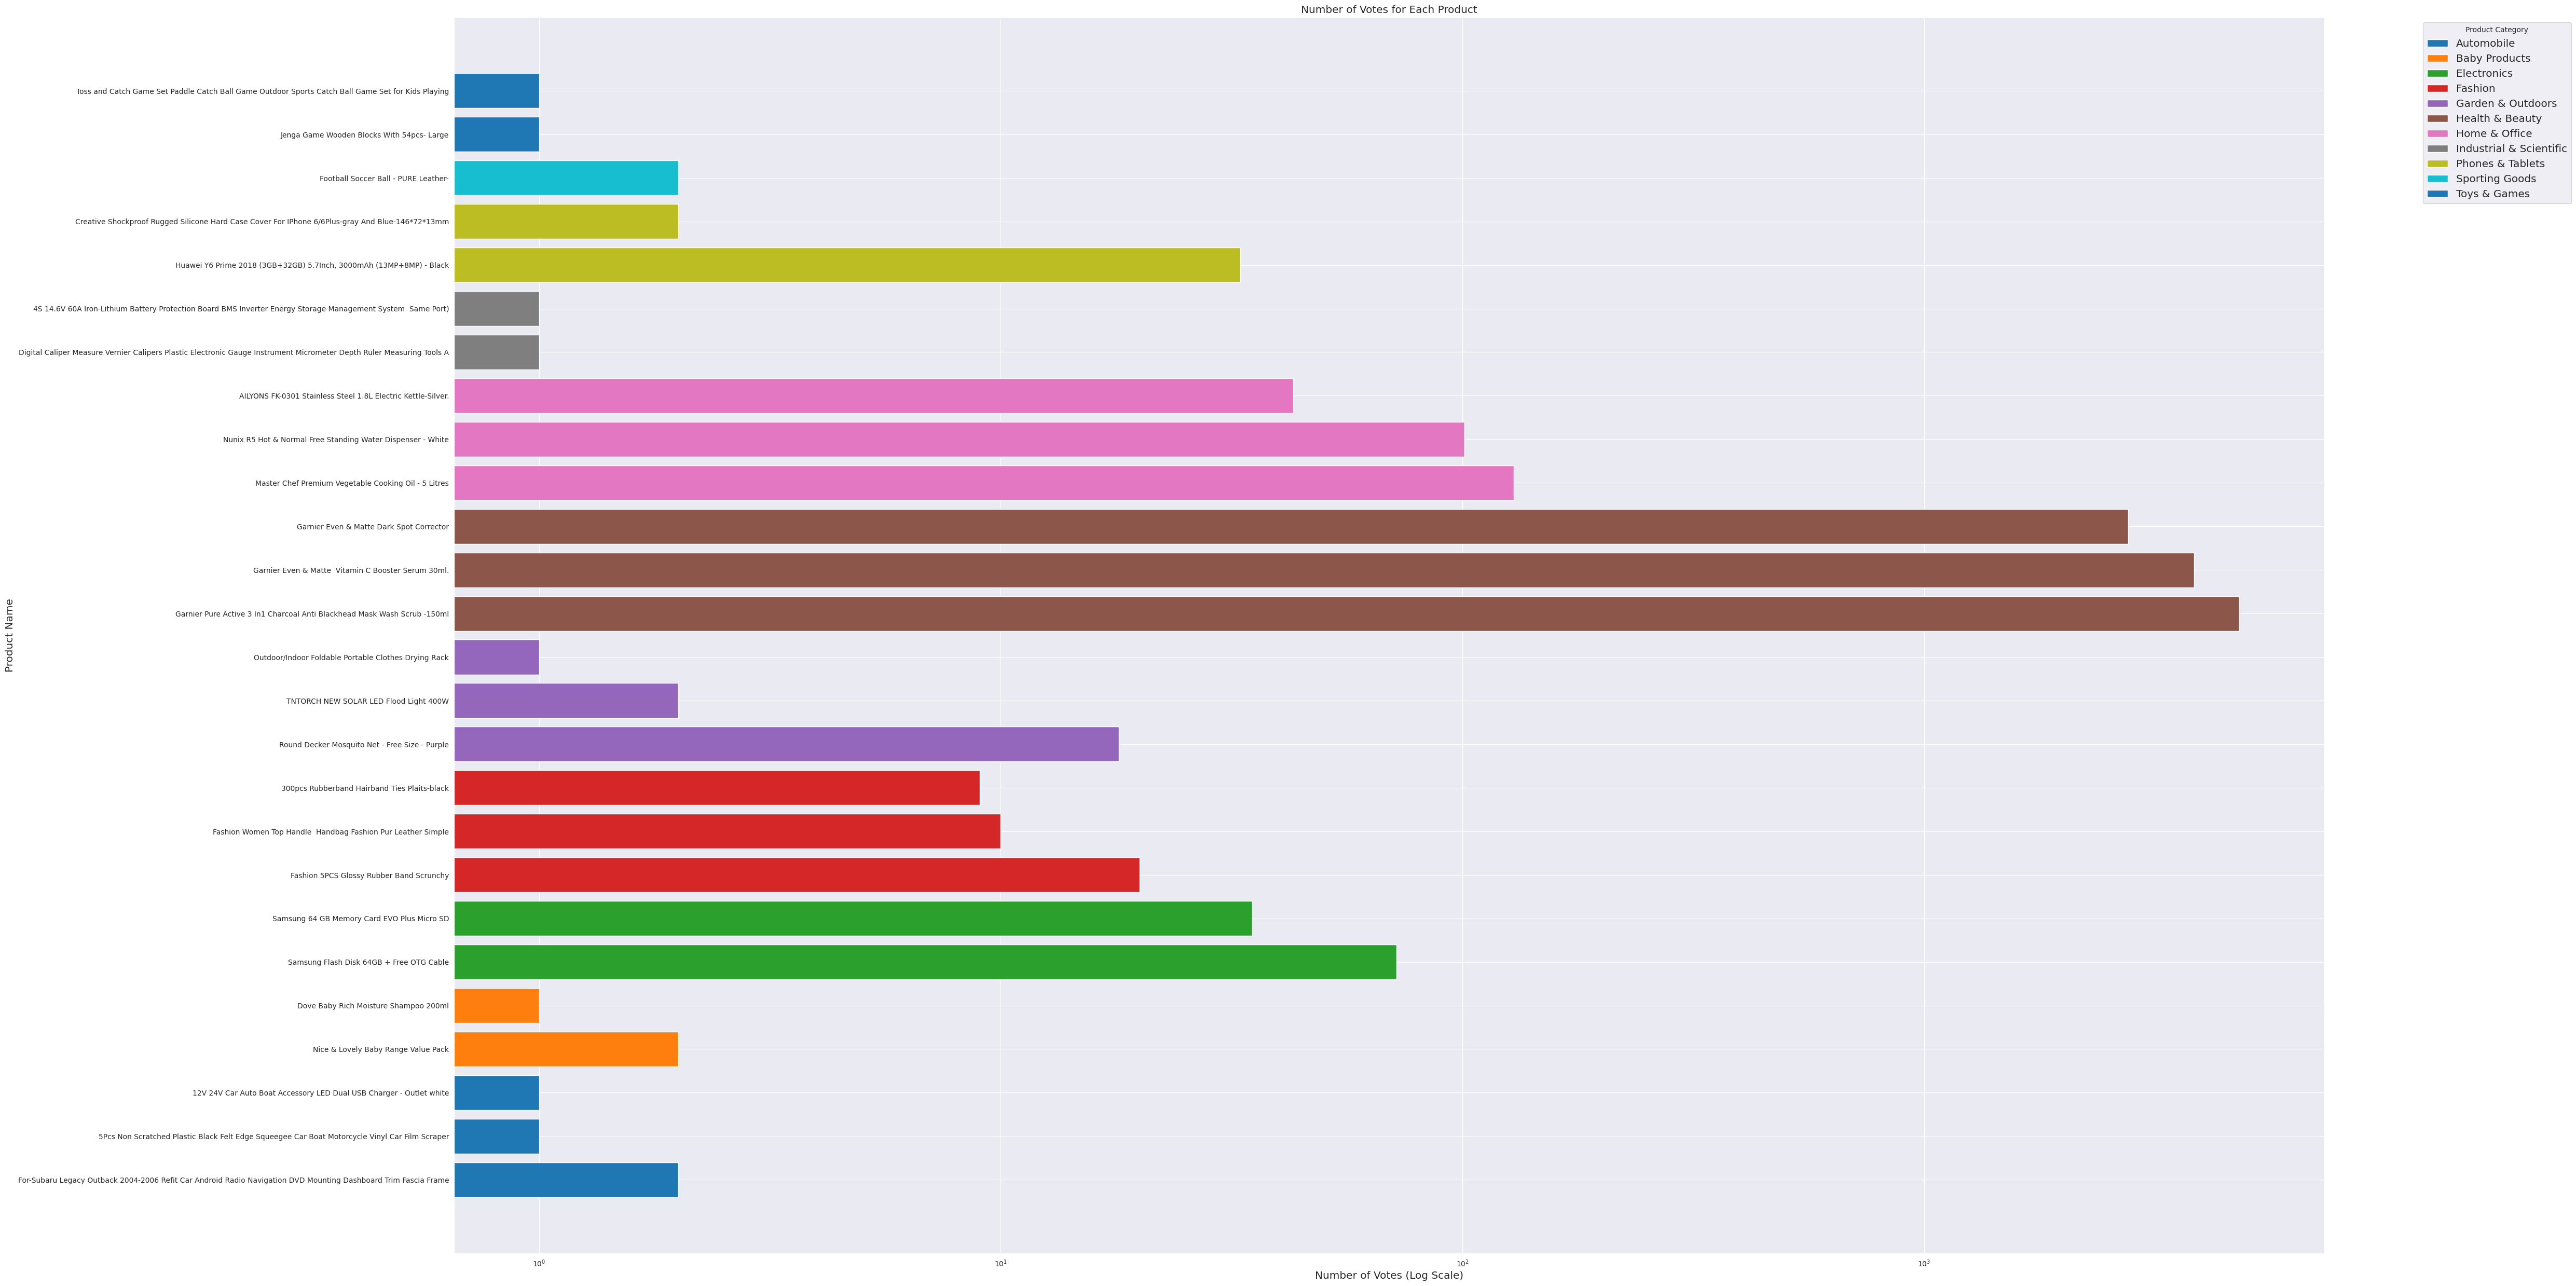

In [177]:
popular_brands_df = pd.read_csv("../results/datafiles/1_popular_brands.csv")

# Set the product category as the index
popular_brands_df.set_index('product_category', inplace=True)
# Remove product names with 0 votes
popular_brands_filtered_df = popular_brands_df[popular_brands_df['votes'] > 0]

# Define a large plot area before plotting
plt.figure(figsize=(50, 25))
# Iteratively plot the category-grouped product names (level=0 reps the product_category index set)
for category, data in popular_brands_filtered_df.groupby(level=0):
    plt.barh(data['name'], data['votes'], label=category)

plt.xscale('log')  # Define x-axis as logarithmic to minimize visual gap between the biggest & smallest values  
# Define x & y labels
plt.xlabel('Number of Votes (Log Scale)', fontsize='x-large')
plt.ylabel('Product Name', fontsize='x-large')

plt.title('Number of Votes for Each Product', fontsize='x-large')  # Title the plot
# Define legend, bbox_to_anchor() = x & y anchor points, loc=location
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-large')
plt.tight_layout(pad=1.5)  # pag flag spaces the title & the plot

# Save plot as png to appropriate folder
plt.savefig('../results/plots/1_popular_brands.png',bbox_inches="tight",pad_inches=2, transparent=False)

#### 2a) Most loved/Most satisfying products (highest rating + 80th percentile of category's votes)

In [178]:
# Get the list of all the categories in the product_category column
categories_list = list(products_clean_df.product_category.unique())

# Sum the votes per category & load into a new dataframe
votes_sum_per_category_df = products_clean_df.groupby('product_category')['votes'].sum().reset_index()

# Filter the product categories with 0 aggregate votes
votes_sum_per_category_filtered_df = votes_sum_per_category_df[votes_sum_per_category_df['votes'] > 0].reset_index(drop=True)
votes_sum_per_category_filtered_df

,product_category,votes
0,Automobile,4.0
1,Baby Products,3.0
2,Electronics,147.0
3,Fashion,50.0
4,Garden & Outdoors,22.0
5,Health & Beauty,30003.0
6,Home & Office,389.0
7,Industrial & Scientific,2.0
8,Phones & Tablets,86.0
9,Sporting Goods,12.0


#### 2b) Create a dictionary with above product_categories (with non-zero votes) as keys & empty lists as values

In [217]:
# Add the categories as keys to the dictionary & empty list as values (to later hold the votes)
categories_dict = {}

for product_cat in votes_sum_per_category_filtered_df['product_category']:
    categories_dict[product_cat] = []
categories_dict

{'Automobile': [],
 'Baby Products': [],
 'Electronics': [],
 'Fashion': [],
 'Garden & Outdoors': [],
 'Health & Beauty': [],
 'Home & Office': [],
 'Industrial & Scientific': [],
 'Phones & Tablets': [],
 'Sporting Goods': [],
 'Toys & Games': []}

#### 2c) Get product names with at least a vote in above categories

In [218]:
indexes_of_rows_with_votes_dict = {}
# Confirm that the 1st 3 values (save on runtime) in the dictionary are empty before running block to fill it
if any(not categories_dict[cat] for cat in list(categories_dict.keys())[:3]):
    for cat in list(categories_dict.keys()):
        filtered_df = products_clean_df[products_clean_df['product_category'] == cat]
        filtered_df_2 = filtered_df[filtered_df['votes'] > 0]
        indexes_of_rows_with_votes_dict[cat] = list(filtered_df_2.index)
        for vote in filtered_df_2['votes']:
            categories_dict[cat].append(vote)

# Sorting the votes lists values in the dictionary in ascending order
# The sorting employs the deepcopy method of the copy module to prevent mutation of original list
categories_dict_sorted = {key: sorted(copy.deepcopy(value)) for key,value in categories_dict.items()}
print(categories_dict_sorted)
print("\n")
print(indexes_of_rows_with_votes_dict)


ratings_of_products_at_selected_votes_indexes = {key: [] for key in indexes_of_rows_with_votes_dict}
# Obtain the ratings at the shortlisted indexes i.e.: indexes_of_rows_with_votes_dict
for key, value in indexes_of_rows_with_votes_dict.items():
    for idx in value:
        ratings_of_products_at_selected_votes_indexes[key].append(products_clean_df.iloc[idx]['rating'])

print(f"\n{ratings_of_products_at_selected_votes_indexes}")

{'Automobile': [1.0, 1.0, 2.0], 'Baby Products': [1.0, 2.0], 'Electronics': [1.0, 1.0, 1.0, 2.0, 35.0, 35.0, 72.0], 'Fashion': [1.0, 1.0, 1.0, 1.0, 2.0, 5.0, 9.0, 10.0, 20.0], 'Garden & Outdoors': [1.0, 1.0, 2.0, 18.0], 'Health & Beauty': [1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 4.0, 7.0, 13.0, 14.0, 16.0, 17.0, 27.0, 31.0, 35.0, 51.0, 109.0, 240.0, 250.0, 311.0, 365.0, 410.0, 426.0, 489.0, 498.0, 663.0, 680.0, 703.0, 721.0, 786.0, 853.0, 1078.0, 1135.0, 1162.0, 1546.0, 1564.0, 2073.0, 2293.0, 2762.0, 3845.0, 4808.0], 'Home & Office': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 6.0, 8.0, 9.0, 13.0, 27.0, 43.0, 101.0, 129.0], 'Industrial & Scientific': [1.0, 1.0], 'Phones & Tablets': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 33.0, 33.0], 'Sporting Goods': [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0], 'Toys & Games': [1.0, 1.0]}


{'Automobile': [264, 530, 7

### Summary stats of the data

In [182]:
summary_stats = products_clean_df.describe()
summary_stats

,new_price,old_price,discount,rating,votes
count,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3501.24100,5831.042070,0.422205,0.291600,15.360000
std,5248.61894,9255.155301,0.097165,1.110584,184.107097
min,59.00000,89.880000,0.010000,0.000000,0.000000
25%,899.00000,1421.500000,0.400000,0.000000,0.000000
50%,1909.00000,3159.000000,0.460000,0.000000,0.000000
75%,3882.50000,6350.000000,0.500000,0.000000,0.000000
max,58699.00000,115209.000000,0.870000,5.000000,4808.000000


### Deriving the correlation matrix

In [183]:
# Returning correlation matrix for only the numerical columns
correlation_matrix = products_clean_df.corr(method='pearson', numeric_only=True)
# correlation_matrix.to_csv("results/datafiles/pearson_correlation.csv")
correlation_matrix

,new_price,old_price,discount,rating,votes
new_price,1.000000,0.955330,-0.042731,-0.000592,-0.034723
old_price,0.955330,1.000000,0.074205,-0.059603,-0.038145
discount,-0.042731,0.074205,1.000000,-0.299764,-0.131882
rating,-0.000592,-0.059603,-0.299764,1.000000,0.308338
votes,-0.034723,-0.038145,-0.131882,0.308338,1.000000


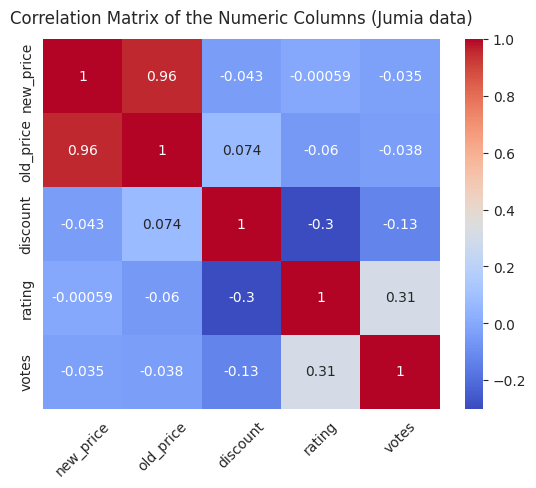

In [184]:
plt.xticks(np.arange(len(products_clean_df.columns)), products_clean_df.columns, rotation=45)
plt.yticks(np.arange(len(products_clean_df.columns)), products_clean_df.columns, rotation=45)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of the Numeric Columns (Jumia data)', y=1.02)

plt.savefig("../results/plots/1_correlation_matrix_of_Jumia_products_numeric_data.png", bbox_inches="tight",pad_inches=2)

### Visualize top-rated products with at least 200 votes

In [185]:
# First filter for products with at least 200 votes (More votes makes a product rating more reliable)
products_with_atleast_200_votes_df = products_clean_df[products_clean_df['votes'] >= 200]
products_with_atleast_200_votes_df

,name,product_category,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,Health & Beauty,912.0,1460.0,0.38,4.7,721.0
2,Garnier Anti-Blemish Charcoal Serum With AHA +...,Health & Beauty,1400.0,1750.0,0.20,4.3,1546.0
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,Health & Beauty,887.0,1560.0,0.43,4.5,2293.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,Health & Beauty,651.0,1040.0,0.37,4.6,680.0
5,Garnier Even & Matte Vitamin C Protection Crea...,Health & Beauty,960.0,1200.0,0.20,4.3,1078.0
6,Garnier Even & Matte Vitamin C Booster Serum ...,Health & Beauty,1400.0,1750.0,0.20,4.4,3845.0
8,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",Health & Beauty,651.0,1040.0,0.37,4.6,853.0
9,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,Health & Beauty,800.0,1302.0,0.39,4.7,1162.0
10,Garnier Even & Matte Vitamin C Booster Serum ...,Health & Beauty,850.0,357.0,0.42,4.2,786.0
11,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,Health & Beauty,1036.0,1295.0,0.20,4.4,4808.0


In [186]:
# Check counts of products with rating at least 4.5
top_rated_products_df = products_with_atleast_200_votes_df[products_with_atleast_200_votes_df['rating'] >= 4.5]
top_rated_products_df

,name,product_category,new_price,old_price,discount,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,Health & Beauty,912.0,1460.0,0.38,4.7,721.0
3,NIVEA Perfect & Radiant Even Tone Day And Nigh...,Health & Beauty,887.0,1560.0,0.43,4.5,2293.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,Health & Beauty,651.0,1040.0,0.37,4.6,680.0
8,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",Health & Beauty,651.0,1040.0,0.37,4.6,853.0
9,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,Health & Beauty,800.0,1302.0,0.39,4.7,1162.0
12,Jameson Jameson Irish Whiskey - 1 Litre,Health & Beauty,2699.0,3827.0,0.29,4.6,250.0
14,NIVEA Lemongrass & Oil Shower Gel For Women - ...,Health & Beauty,675.0,1190.0,0.43,4.6,663.0
18,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,Health & Beauty,2182.0,3840.0,0.43,4.6,426.0
20,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,Health & Beauty,3647.0,5610.0,0.35,4.5,365.0
24,Garnier Vitamin C Booster Serum 30ml Twin Pack,Health & Beauty,2975.0,3500.0,0.15,4.6,498.0


In [187]:
# Selecting only votes & rating column before plotting
new_top_rated_products_df = top_rated_products_df[['name','rating', 'votes']].reset_index(drop=True)
new_top_rated_products_df

,name,rating,votes
0,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,4.7,721.0
1,NIVEA Perfect & Radiant Even Tone Day And Nigh...,4.5,2293.0
2,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,4.6,680.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",4.6,853.0
4,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,4.7,1162.0
5,Jameson Jameson Irish Whiskey - 1 Litre,4.6,250.0
6,NIVEA Lemongrass & Oil Shower Gel For Women - ...,4.6,663.0
7,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,4.6,426.0
8,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,4.5,365.0
9,Garnier Vitamin C Booster Serum 30ml Twin Pack,4.6,498.0


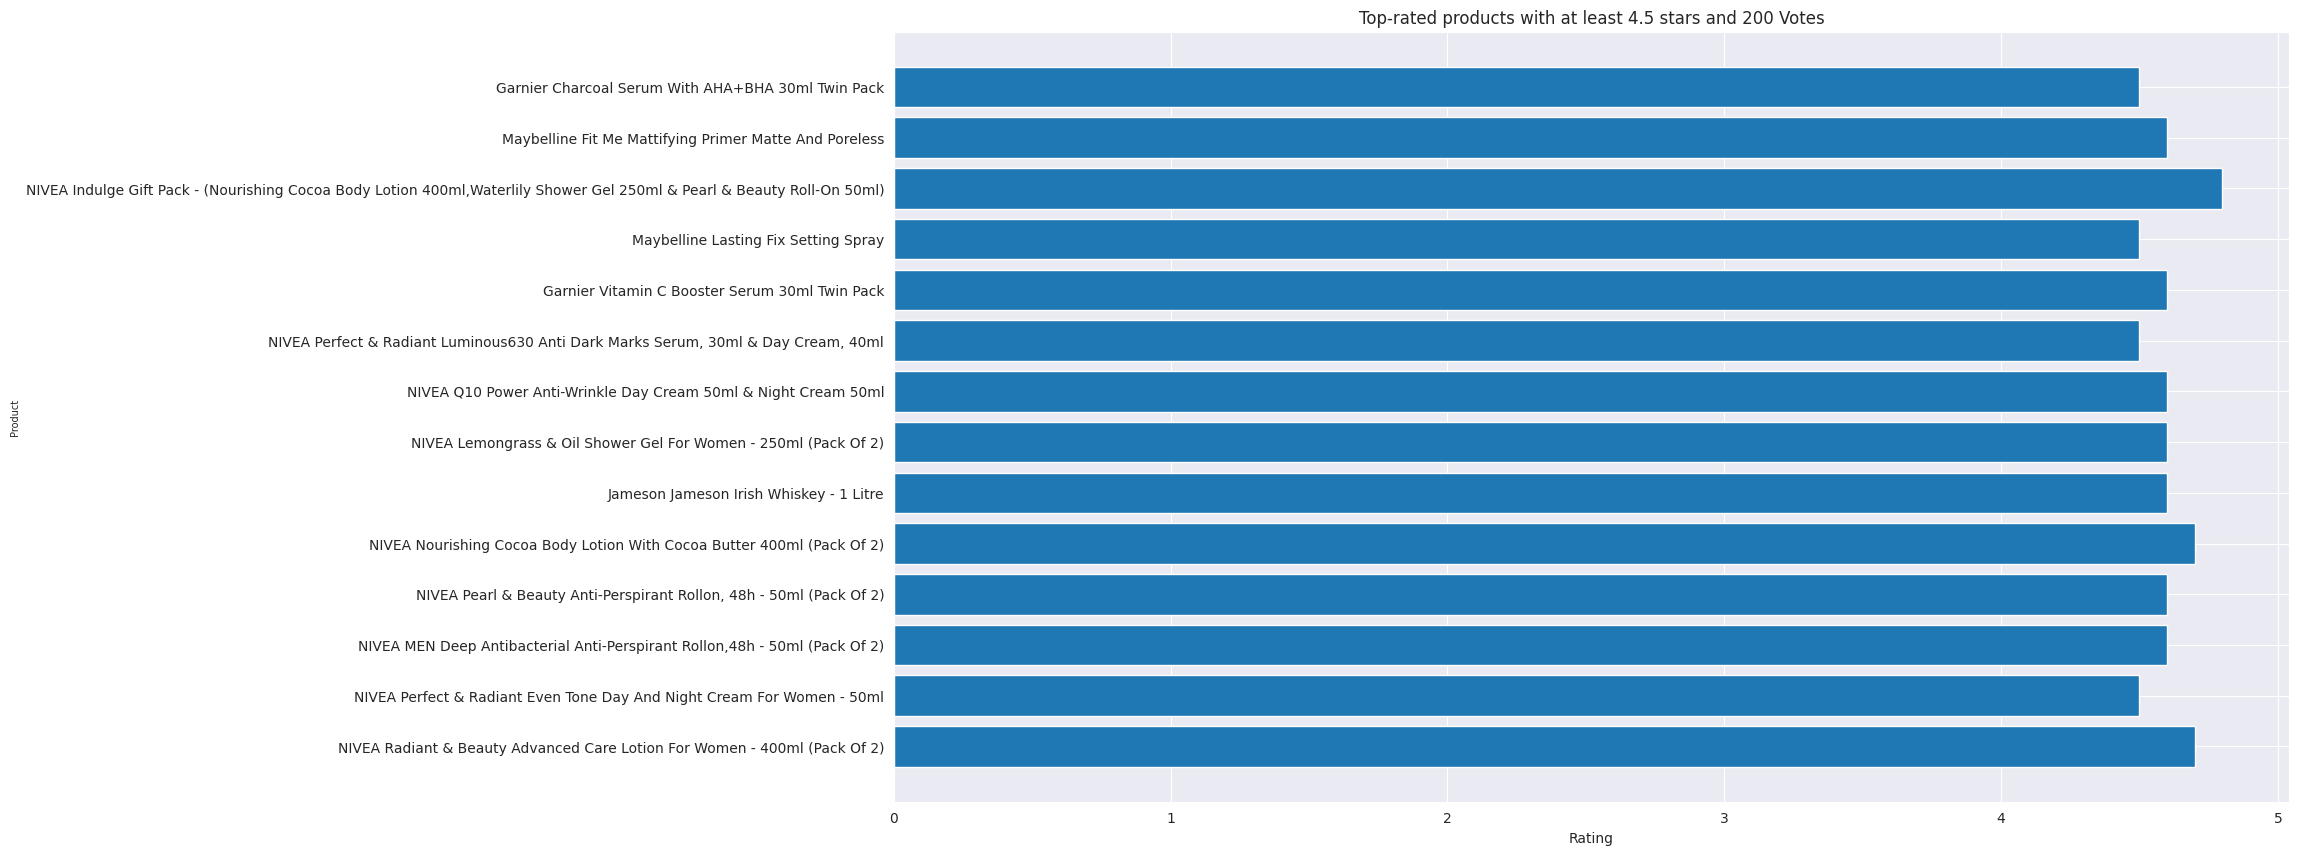

In [188]:
# Creating a horizontal bar plot
plt.figure(figsize=(18,10))

plt.barh(new_top_rated_products_df['name'], new_top_rated_products_df['rating'])

plt.title("Top-rated products with at least 4.5 stars and 200 Votes")
plt.ylabel("Product", fontsize=7)
plt.xlabel("Rating")

# Save the plot to file
plt.savefig("../results/plots/2_products_4.5_stars_and_more_than_200_votes.png",bbox_inches='tight',pad_inches=2)

### Showing product price distribution: Histogram with Kernel density estimate (kde) curve

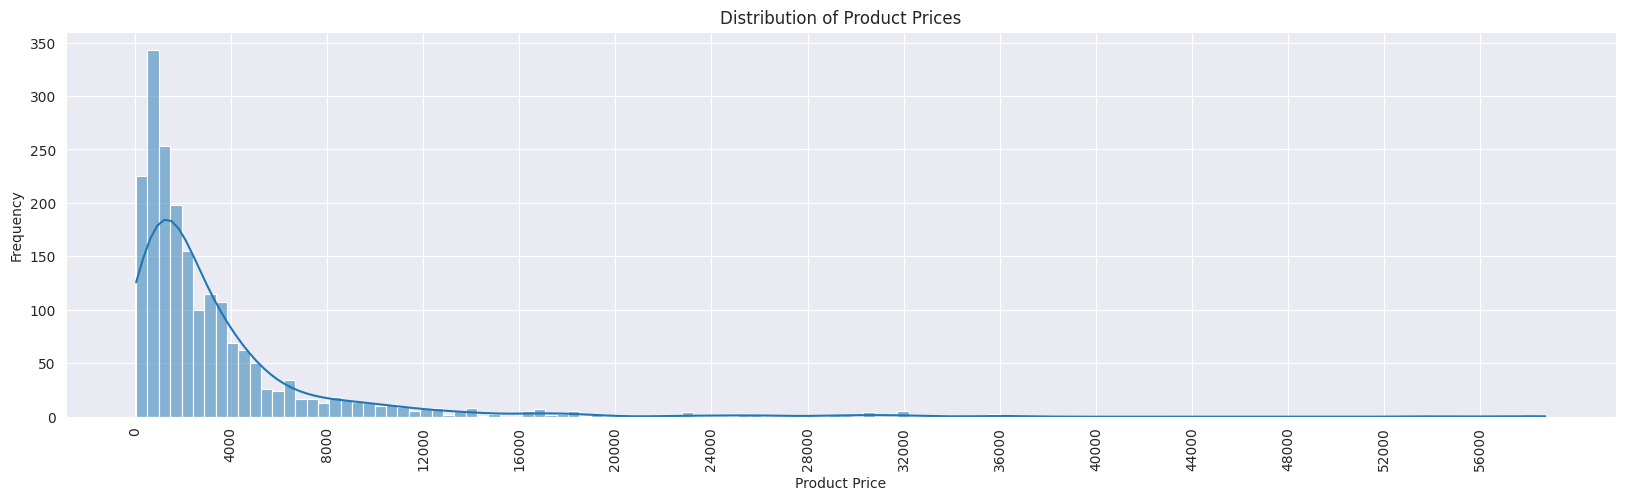

In [189]:
plt.figure(figsize=(20, 5))
sns.histplot(products_clean_df['new_price'], kde=True)
plt.xlabel('Product Price')
plt.xticks(np.arange(0, max(products_clean_df['new_price'])+1, 4000),rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices')

# Save the plot to file
plt.savefig("../results/plots/3_product_prices_histogram_with_kernel_estimate_curve.png",bbox_inches='tight',pad_inches=1)

### Visualizing discount distribution

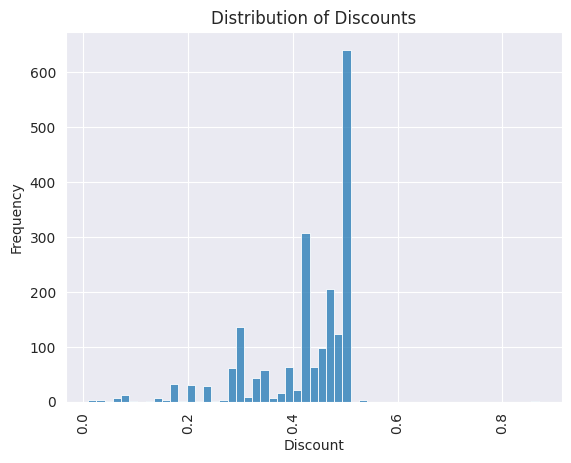

In [190]:
sns.histplot(products_clean_df['discount'])
plt.xlabel('Discount')
# plt.xticks(np.arange(0,max(products_clean_df['discount'])+1,0.5),rotation=90)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Discounts')

# Save the plot to file
plt.savefig("../results/plots/4_product_discount_histogram.png",bbox_inches='tight',pad_inches=1)

### Visualizing rating distribution

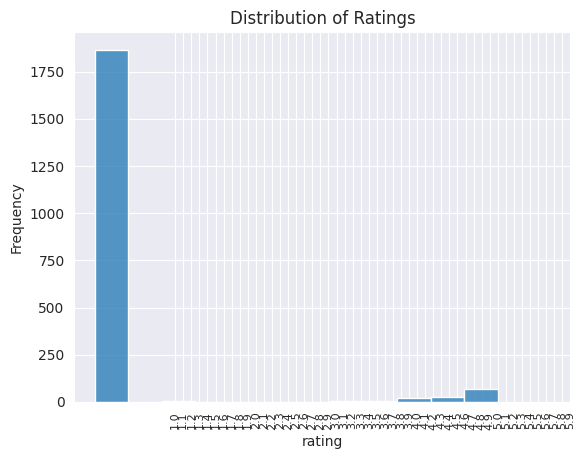

In [191]:
sns.histplot(data=products_clean_df, x='rating')
plt.title('Distribution of Ratings')
plt.xticks(np.arange(1.0, max(products_clean_df['rating'])+1, 0.1),rotation=90,fontsize=8)
plt.ylabel("Frequency")

# Save plot to file
plt.savefig("../results/plots/5_ratings_distribution_histogram.png", bbox_inches="tight", pad_inches=1)

### Product Name Analysis

In [192]:
words = ' '.join(products_clean_df['name']).split()
all_words = Counter(words)
# len(all_words)  # 4580

# Returning an array of tuples with all_words & their counts, then return first 10
all_words_counts = all_words.most_common()
all_words_counts[:10]

[('For', 375),
 ('for', 304),
 ('915', 207),
 ('Generation', 207),
 ('Case', 199),
 ('Fashion', 158),
 ('Car', 132),
 ('Cover', 117),
 ('-', 94),
 ('Light', 93)]

In [193]:
# Return only the alphabetical elements & their counts, & return the first 10
only_alpha_words_list = [(word, count) for word, count in all_words_counts if word.isalpha()]
only_alpha_words_list[:10]

[('For', 375),
 ('for', 304),
 ('Generation', 207),
 ('Case', 199),
 ('Fashion', 158),
 ('Car', 132),
 ('Cover', 117),
 ('Light', 93),
 ('with', 89),
 ('Phone', 89)]

In [194]:
# Select the top 30 words
first_30_words = only_alpha_words_list[:31]
first_30_words

# Future: Use library to remove conjuctions such as 'and' from this list

[('For', 375),
 ('for', 304),
 ('Generation', 207),
 ('Case', 199),
 ('Fashion', 158),
 ('Car', 132),
 ('Cover', 117),
 ('Light', 93),
 ('with', 89),
 ('Phone', 89),
 ('With', 86),
 ('Galaxy', 83),
 ('Set', 78),
 ('Power', 76),
 ('Samsung', 74),
 ('Leather', 72),
 ('USB', 69),
 ('LED', 63),
 ('Black', 62),
 ('Cable', 61),
 ('Digital', 60),
 ('Portable', 60),
 ('Kitchen', 59),
 ('Card', 59),
 ('Holder', 58),
 ('Women', 57),
 ('Bag', 57),
 ('Screen', 55),
 ('Box', 54),
 ('Mini', 54),
 ('Glass', 53)]

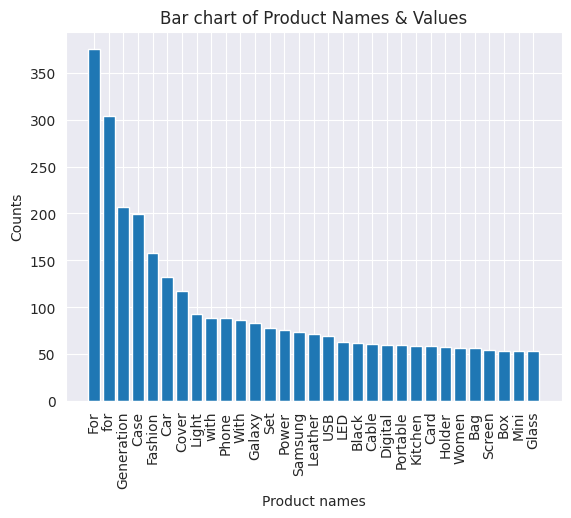

In [195]:
# Plot a chart with the first 30 words
plt.bar([d[0] for d in first_30_words], [d[1] for d in first_30_words])
plt.xlabel("Product names")
plt.xticks(rotation=90)
plt.ylabel("Counts")
plt.title("Bar chart of Product Names & Values")

# Save plot to file
plt.savefig("../results/plots/6_barchart_top_30_product_names_counts.png", bbox_inches="tight", pad_inches=1)

### Creating pairplot showing relationship between various numerical columns

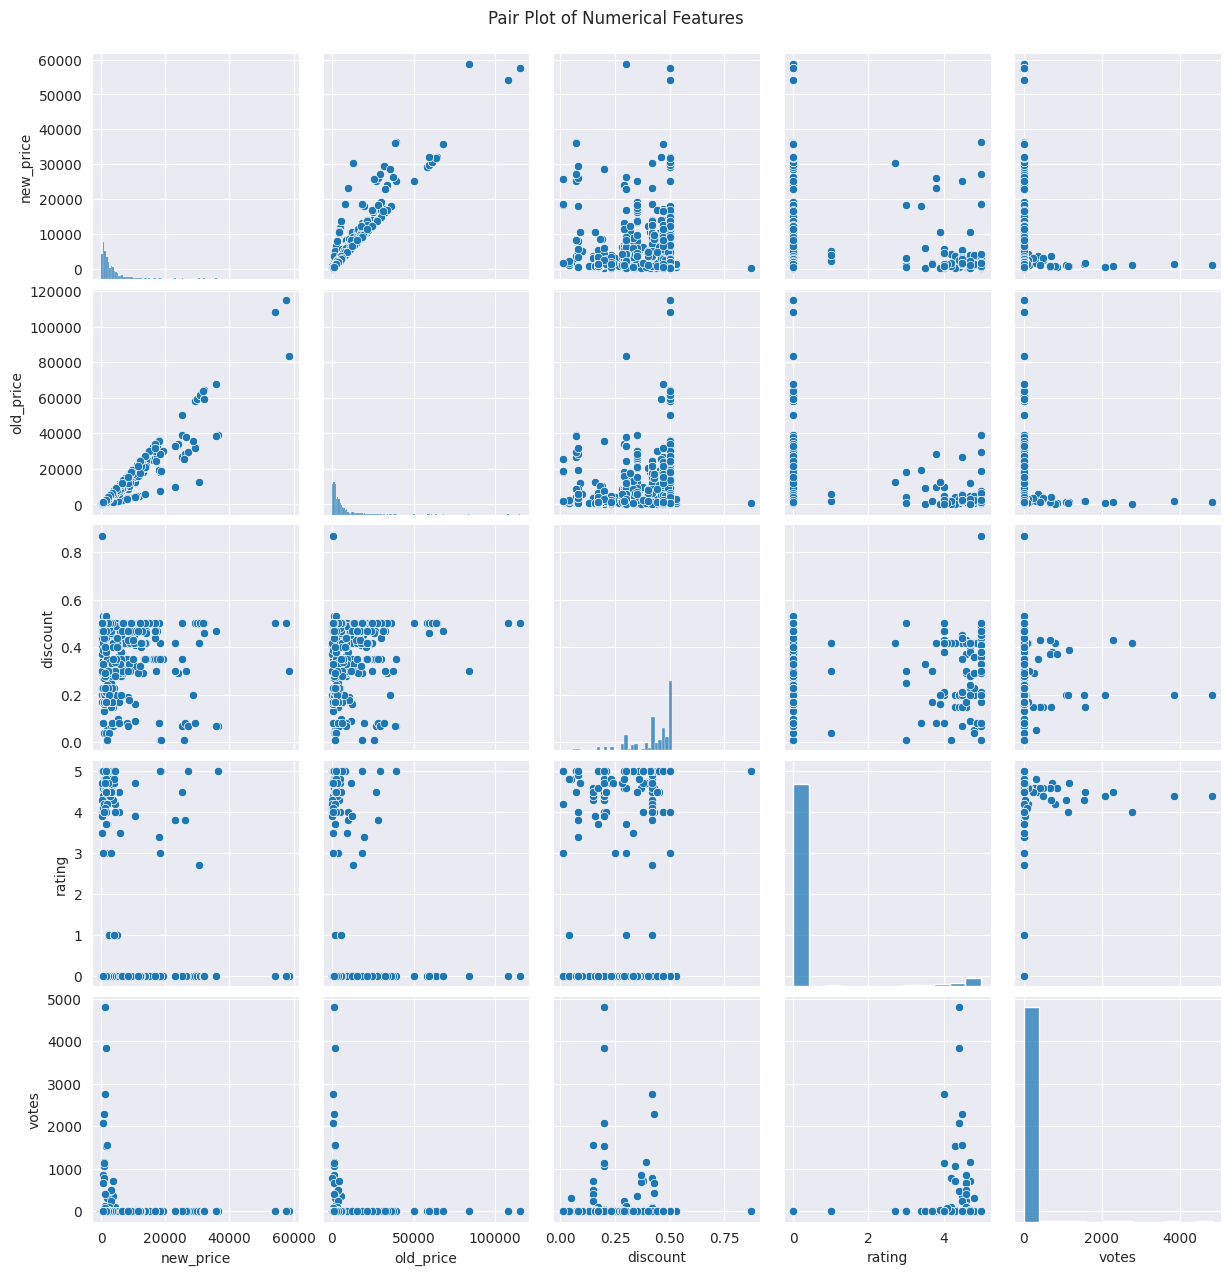

In [196]:
sns.pairplot(products_clean_df)
plt.suptitle('Pair Plot of Numerical Features', y=1.02)

# Save to file
plt.savefig("../results/plots/7_pairplot_rltnships_between_all_numerical_columns.png", bbox_inches="tight", pad_inches=1)